In [1]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
%matplotlib inline

In [21]:
block_size = 1024
vocab_size = 50257
n_layer = 4
n_head = 4
n_embd = 128


# A100 is cited to be 312 TFLOPS of bloat16 running on tensor cores
a100_flops_promised = 312e12
tokens_num = 10e6 # this is dataset size in tokens, D
a100_flops = 312e12 # 312 TFLOPS
n_a100 = 1 # number of A100s

batch_size = 20 * 5 # 5 is grad_accum, so total batch size is 100
measured_time = 0.400 # in seconds per iteration
assumed_mfu = 0.17 # assume this model flops utilization (take the value from below, depending on measured time and  and add some DDP overhead)


#Loss parameters 
# E = 1.69
# A = 406.4
# B = 410.7
# alpha = 0.34
# beta = 0.28


bias = False
assert not bias, "this notebook assumes bias=False just for simplicity"

In [22]:
def gpt_params(seq_len, vocab_size, d_model, num_heads, num_layers):
    """ Given GPT config calculate total number of parameters """
    ffw_size = 4*d_model # in GPT the number of intermediate features is always 4*d_model
    # token and position embeddings
    embeddings = d_model * vocab_size + d_model * seq_len
    # transformer blocks
    attention = 3*d_model**2 + 3*d_model # weights and biases
    attproj = d_model**2 + d_model
    ffw = d_model*(ffw_size) + ffw_size
    ffwproj = ffw_size*d_model + d_model
    layernorms = 2*2*d_model
    # dense
    ln_f = 2*d_model
    dense = d_model*vocab_size # note: no bias here
    # note: embeddings are not included in the param count!
    total_params = num_layers*(attention + attproj + ffw + ffwproj + layernorms) + ln_f + dense
    return total_params



In [24]:
gpt2 = dict(seq_len = block_size, vocab_size = vocab_size, d_model = n_embd, num_heads = n_head, num_layers = n_layer)
gpt_params(**gpt2)

7226240

In [25]:
def params():
    """ estimates the number of parameters in the model"""
    out = OrderedDict()

    # token and position embeddings
    out['emebedding/position'] = n_embd * block_size
    out['embedding/token'] = n_embd * vocab_size
    out['embedding'] = out['emebedding/position'] + out['embedding/token']

    # attention blocks
    out['attention/ln'] = n_embd # note, bias=False in our LN
    out['attention/kqv'] = n_embd * 3*n_embd
    out['attention/proj'] = n_embd**2
    out['attention'] = out['attention/ln'] + out['attention/kqv'] + out['attention/proj']

    # MLP blocks
    ffw_size = 4*n_embd # feed forward size
    out['mlp/ln'] = n_embd
    out['mlp/ffw'] = n_embd * ffw_size
    out['mlp/proj'] = ffw_size * n_embd
    out['mlp'] = out['mlp/ln'] + out['mlp/ffw'] + out['mlp/proj']
    
    # the transformer and the rest of it
    out['block'] = out['attention'] + out['mlp']
    out['transformer'] = n_layer * out['block']
    out['ln_f'] = n_embd # final layernorm
    out['dense'] = 0 # 0 because of parameter sharing. This layer uses the weights from the embedding layer

    # total
    out['total'] = out['embedding'] + out['transformer'] + out['ln_f'] + out['dense']

    return out

# compare our param count to that reported by PyTorch
p = params()
params_total = p['total']
print(f"we see: {params_total}, expected: {124337664}, match: {params_total == 124337664}")
# create a header
print(f"{'name':20s} {'params':10s} {'ratio (%)':10s}")
for k,v in p.items():
    print(f"{k:20s} {v:10d} {v/params_total*100:10.4f}")
    

we see: 7351552, expected: 124337664, match: False
name                 params     ratio (%) 
emebedding/position      131072     1.7829
embedding/token         6432896    87.5039
embedding               6563968    89.2868
attention/ln                128     0.0017
attention/kqv             49152     0.6686
attention/proj            16384     0.2229
attention                 65664     0.8932
mlp/ln                      128     0.0017
mlp/ffw                   65536     0.8915
mlp/proj                  65536     0.8915
mlp                      131200     1.7847
block                    196864     2.6779
transformer              787456    10.7114
ln_f                        128     0.0017
dense                         0     0.0000
total                   7351552   100.0000


In [14]:
def flops():
    # we only count Weight FLOPs, all other layers (LayerNorm, Softmax, etc) are effectively irrelevant
    # we count actual FLOPs, not MACs. Hence 2* all over the place
    # basically for any matrix multiply A (BxC) @ B (CxD) -> (BxD) flops are 2*B*C*D

    out = OrderedDict()
    head_size = n_embd // n_head

    # attention blocks
    # 1) the projection to key, query, values
    out['attention/kqv'] = 2 * block_size * (n_embd * 3*n_embd)
    # 2) calculating the attention scores
    out['attention/scores'] = 2 * block_size * block_size * n_embd
    # 3) the reduction of the values (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
    out['attention/reduce'] = 2 * n_head * (block_size * block_size * head_size)
    # 4) the final linear projection
    out['attention/proj'] = 2 * block_size * (n_embd * n_embd)
    out['attention'] = sum(out['attention/'+k] for k in ['kqv', 'scores', 'reduce', 'proj'])

    # MLP blocks
    ffw_size = 4*n_embd # feed forward size
    out['mlp/ffw1'] = 2 * block_size * (n_embd * ffw_size)
    out['mlp/ffw2'] = 2 * block_size * (ffw_size * n_embd)
    out['mlp'] = out['mlp/ffw1'] + out['mlp/ffw2']

    # the transformer and the rest of it
    out['block'] = out['attention'] + out['mlp']
    out['transformer'] = n_layer * out['block']
    out['dense'] = 2 * block_size * (n_embd * vocab_size)

    # forward,backward,total
    out['forward_total'] = out['transformer'] + out['dense']
    out['backward_total'] = 2 * out['forward_total'] # use common estimate of bwd = 2*fwd
    out['total'] = out['forward_total'] + out['backward_total']

    return out
    
# compare our param count to that reported by PyTorch
f = flops()
# here is what we currently roughly measure

measured_throughput = batch_size / measured_time
flops_achieved = f['total'] * measured_throughput



# the fraction of the A100 that we are using:
print(f"fraction of A100 used: {flops_achieved / a100_flops_promised * 100:.2f}%")

fraction of A100 used: 14.53%


In [31]:
def time_to_train(model_size, n_a100, assumed_mfu, a100_flops, tokens_num):

    """ estimates the time to train the model """
    
    flops_throughput = a100_flops * n_a100 * assumed_mfu
    flops_needed = 6 * model_size * tokens_num # 6ND formula from Chinchilla paper
    time_needed = flops_needed / flops_throughput # in seconds

    return time_needed

def L(N, D):
    """ 
    Approximates loss given N parameters and D dataset size (in tokens),
    per Chinchilla paper.
    """
    E = 1.69 # entropy of natural language, limit of infinite model on infinite data
    A = 406.4
    B = 410.7
    alpha = 0.34
    beta = 0.28
    return A / (N ** alpha) + B / (D ** beta) + E


In [15]:
# Finally let's check out the 6ND approximation as total cost of training in FLOPs
model_size = params()['total'] # this is number of parameters, N

flops_throughput = a100_flops * n_a100 * assumed_mfu # assume an 8XA100 node at 30% utilization
flops_needed = 6 * model_size * tokens_num # 6ND
time_needed_s = flops_needed / flops_throughput # in seconds
print(f"time needed to train the model: {time_needed_s/3600:.2f} hours")

time needed to train the model: 0.01 hours


In [39]:
#List of models to compare

# Model name, n_heads, n_layers, n_embd, block_size

models = {"gpt2_small_124M": (12, 12, 768, 1024),
          "gpt2_6x6": (6, 6, 384, 1024),
          "gpt2_8x16": (8, 16, 512, 1024),
          "gpt2_4x4": (4,4,128,1024),
}

dataset_sizes = {
    "wikipedia_10M": 1320000,
    "simple_wikipedia_10M": 2030000,
    "full_10M": 13280000,
    "wikipedia_100M": 13440000,
    "simple_wikipedia_100M": 19540000,
    "full_100M": 130720000
}


    

In [44]:
# Pandas data frame to store the results of Flops calculated for each model for each dataset

df = pd.DataFrame(columns=["Model", "n_heads", "n_layers", "n_embd", "block_size", "Dataset", "Flops", "Time to train", "Loss"])
row_list = []
for model, model_params in models.items():
    model_name = model
    n_head, n_layer, n_embd, block_size = model_params
    for dataset, dataset_size in dataset_sizes.items():    
        flops = flops_throughput * time_to_train(gpt_params(block_size, vocab_size, n_embd, n_head, n_layer), n_a100, assumed_mfu, a100_flops, dataset_size)
        time_to_train_model = time_to_train(gpt_params(block_size, vocab_size, n_embd, n_head, n_layer), n_a100, assumed_mfu, a100_flops, dataset_size)
        loss = L(gpt_params(block_size, vocab_size, n_embd, n_head, n_layer), dataset_size)
        row_list.append({"Model": model_name, "n_heads": n_head, "n_layers": n_layer, "n_embd": n_embd, "block_size": block_size, "Dataset": dataset, "Flops": flops, "Time to train": time_to_train_model, "Loss": loss})

df = pd.DataFrame(row_list)
df.sort_values(by=["Loss"], inplace=True)

In [45]:
df

,Model,n_heads,n_layers,n_embd,block_size,Dataset,Flops,Time to train,Loss
5,gpt2_small_124M,12,12,768,1024,full_100M,9.698382e+16,1828.503316,4.602997
17,gpt2_8x16,8,16,512,1024,full_100M,5.974224e+16,1126.362070,4.732013
11,gpt2_6x6,6,6,384,1024,full_100M,2.348743e+16,442.824943,5.049350
23,gpt2_4x4,4,4,128,1024,full_100M,5.667685e+15,106.856798,5.774557
4,gpt2_small_124M,12,12,768,1024,simple_wikipedia_100M,1.449712e+16,273.324318,6.143517
16,gpt2_8x16,8,16,512,1024,simple_wikipedia_100M,8.930259e+15,168.368382,6.272533
3,gpt2_small_124M,12,12,768,1024,wikipedia_100M,9.971408e+15,187.997893,6.555911
2,gpt2_small_124M,12,12,768,1024,full_10M,9.852701e+15,185.759823,6.569836
10,gpt2_6x6,6,6,384,1024,simple_wikipedia_100M,3.510897e+15,66.193386,6.589870
15,gpt2_8x16,8,16,512,1024,wikipedia_100M,6.142409e+15,115.807116,6.684927


In [27]:
raw = [
    [400e6, 7.7e9],
    [1e9, 20.0e9],
    [10e9, 219.5e9],
    [67e9, 1.7e12],
    [175e9, 4.3e12],
    [280e9, 7.1e12],
    [520e9, 13.4e12],
    [1e12, 26.5e12],
    [10e12, 292.0e12],
]


In [17]:
import numpy as np
x = np.array([np.log10(x[0]) for x in raw])
y = np.array([np.log10(x[1]) for x in raw])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
print(f"y = {m}x + {c}")

y = 1.0409573169995876x + 0.9353887152390992


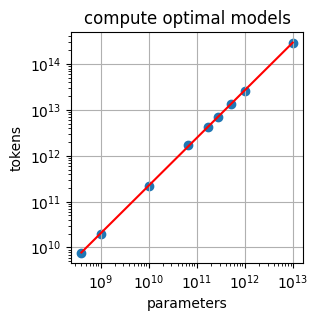

In [18]:
plt.figure(figsize=(3, 3))
# plot the line
plt.plot([q[0] for q in raw], [10**(m*np.log10(q[0]) + c) for q in raw], label='linear regression', color='r')
# plot the raw data
plt.scatter([q[0] for q in raw], [q[1] for q in raw], label='raw data')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('parameters')
plt.ylabel('tokens')
plt.title('compute optimal models')
plt.grid()


In [19]:
xquery = 124e6 # query model size here (e.g. GPT-2 small is 124M)
yquery = 10**(m*np.log10(xquery) + c)
print(f"predicted tokens for {xquery:e} parameters: {yquery:e}")

predicted tokens for 1.240000e+08 parameters: 2.292426e+09


In [20]:
# fit a line by linear regression to the raw data
import numpy as np
y = np.array([np.log10(x[0]) for x in raw])
x = np.array([np.log10(x[1]) for x in raw])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
print(f"y = {m}x + {c}")

y = 0.9606135203483412x + -0.8980869297587444


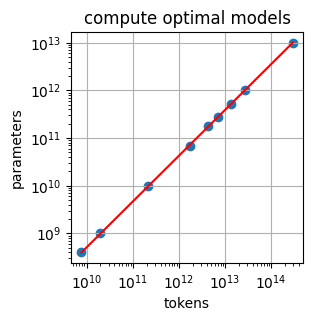

In [42]:
plt.figure(figsize=(3, 3))
# plot the line
plt.plot([q[1] for q in raw], [10**(m*np.log10(q[1]) + c) for q in raw], label='linear regression', color='r')
# plot the raw data
plt.scatter([q[1] for q in raw], [q[0] for q in raw], label='raw data')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('parameters')
plt.xlabel('tokens')
plt.title('compute optimal models')
plt.grid()


In [43]:
xquery = 10000000 # query dataset ize here 
yquery = 10**(m*np.log10(xquery) + c)
print(f"predicted parameters for {xquery:e} tokens: {yquery}")

predicted parameters for 1.000000e+07 tokens: 670205.0758578306
